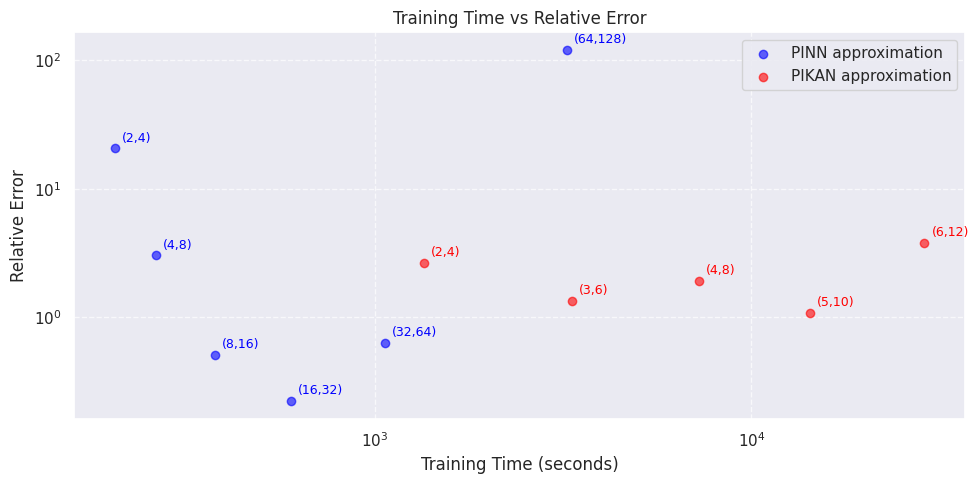

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from utils.styled_plots import plot_log
import seaborn as sns

def natural_sort_key(s):
    """Function to sort strings with numbers in natural order"""
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split('([0-9]+)', s)]

# Paths to the folders
errors_path = "results/errors"
times_path = "results/training_times"

# Lists to store our data
errors = []
times = []
labels = []

# Read all CSV files from both directories
error_files = sorted(os.listdir(errors_path), key=natural_sort_key)
time_files = sorted(os.listdir(times_path), key=natural_sort_key)

# Read error files
for file_name in error_files:
    if file_name.endswith('.csv'):
        file_path = os.path.join(errors_path, file_name)
        with open(file_path, 'r') as file:
            value = float(file.read().strip())
            errors.append(value)
            # Extract the parameters from filename (assuming format like "relative_error(8,16).csv")
            params = re.findall(r'\((\d+),(\d+)\)', file_name)
            if params:
                labels.append(f"({params[0][0]},{params[0][1]})")

# Read time files
for file_name in time_files:
    if file_name.endswith('.csv'):
        file_path = os.path.join(times_path, file_name)
        # In your file reading loop, replace:
        with open(file_path, 'r') as file:
            time_str = file.read().strip()
            value = time_to_seconds(time_str)
            times.append(value)


# Paths to the folders
errors_path2 = "results_kan/errors"
times_path2 = "results_kan/training_times"

# Lists to store our data
errors2 = []
times2 = []
labels2 = []

# Read all CSV files from both directories
error_files2 = sorted(os.listdir(errors_path2), key=natural_sort_key)
time_files2= sorted(os.listdir(times_path2), key=natural_sort_key)

# Read error files
for file_name in error_files2:
    if file_name.endswith('.csv'):
        file_path = os.path.join(errors_path2, file_name)
        with open(file_path, 'r') as file:
            value = float(file.read().strip())
            errors2.append(value)
            # Extract the parameters from filename (assuming format like "relative_error(8,16).csv")
            params = re.findall(r'\((\d+),(\d+)\)', file_name)
            if params:
                labels2.append(f"({params[0][0]},{params[0][1]})")

# Read time files
for file_name in time_files2:
    if file_name.endswith('.csv'):
        file_path = os.path.join(times_path2, file_name)
        # In your file reading loop, replace:
        with open(file_path, 'r') as file:
            time_str = file.read().strip()
            value = time_to_seconds(time_str)
            times2.append(value)
# Create the scatter plot


sns.set_theme(style="darkgrid")

plt.figure(figsize=(10, 5))

plt.scatter(times, errors, alpha=0.6, label="PINN approximation", color="blue", zorder = 2)
for i, label in enumerate(labels):
    plt.annotate(label,
                 (times[i], errors[i]),
                 xytext=(5, 5),
                 textcoords='offset points',
                 fontsize=9,
                 color="blue",
                 zorder=5)

plt.scatter(times2, errors2, alpha=0.6, label="PIKAN approximation", color="red", zorder = 2)
for i, label in enumerate(labels2):
    plt.annotate(label,
                 (times2[i], errors2[i]),
                 xytext=(5, 5),
                 textcoords='offset points',
                 fontsize=9,
                 color="red",
                 zorder=5)


plt.xscale('log')  # Make x-axis logarithmic
plt.yscale('log')  # Make y-axis logarithmic

plt.xlabel('Training Time (seconds)')
plt.ylabel('Relative Error')
plt.title('Training Time vs Relative Error')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.savefig("errors.pdf")
plt.show()



In [2]:
def time_to_seconds(time_str):
    """Convert time string in format 'H:MM:SS.microseconds' to seconds"""
    # Split on ':' to get hours, minutes, and seconds
    parts = time_str.split(':')
    
    if len(parts) == 3:  # Format is H:MM:SS.microseconds
        hours, minutes, seconds = parts
    elif len(parts) == 2:  # Format is MM:SS.microseconds
        hours = '0'
        minutes, seconds = parts
    else:
        raise ValueError(f"Unexpected time format: {time_str}")
    
    # Convert to float
    total_seconds = (
        float(hours) * 3600 +    # hours to seconds
        float(minutes) * 60 +    # minutes to seconds
        float(seconds)           # seconds and microseconds already in seconds
    )
    
    return total_seconds





In [1]:
import numpy as np
from utils.styled_plots import plot_styled_k, plot_styled_waves

x_vals = np.linspace(-3, 3, 150)
y_vals = np.linspace(-3, 3, 150)
X_mesh, Y_mesh = np.meshgrid(x_vals, y_vals)

alpha = 0.5
beta = 10
epsilon = 1

u_true = np.exp(-alpha * (X_mesh**2 + Y_mesh**2)) * np.cos(beta * Y_mesh)
k_true = 1 + 2 / (1 + np.exp(-Y_mesh / epsilon))    
figu,axu = plot_styled_waves(X_mesh, Y_mesh, u_true, title="Analytic u (Infinite domain)", saveas="anl/u_real.pdf")
figu,axu = plot_styled_k(X_mesh, Y_mesh, k_true, title="Analytic k (Infinite domain)", saveas="anl/k_real.pdf")

In [ ]:
#pLOT UBND

u_true = torch.exp(-alpha * x**2) * torch.cos(beta * x)


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

from utils.styled_plots import plot_styled_k, plot_styled_waves

class MLP_u(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_units, activation_function):
        super(MLP_u, self).__init__()
        self.linear_in = nn.Linear(input_size, hidden_units)
        self.linear_out = nn.Linear(hidden_units, output_size)
        self.layers = nn.ModuleList([nn.Linear(hidden_units, hidden_units) for _ in range(hidden_layers)])
        self.act = activation_function

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear_in(x)
        for layer in self.layers:
            x = self.act(layer(x))
        x = self.linear_out(x)
        return x

    
class MLP_k(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_units, activation_function):
        super(MLP_k, self).__init__()
        self.linear_in = nn.Linear(input_size, hidden_units)
        self.linear_out = nn.Linear(hidden_units, output_size)
        self.layers = nn.ModuleList([nn.Linear(hidden_units, hidden_units) for _ in range(hidden_layers)])
        self.act = activation_function

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear_in(x)
        for layer in self.layers:
            x = self.act(layer(x))
        x = self.linear_out(x)
        return x
    
model = torch.load(
    "/Users/gregorioperez/Documents/PINNS/PINN-PIKAN-Poisson/infinite/results/models/model_u(16,32).pth",
    map_location="cpu",
    weights_only=False
)
model.eval()
modelk = torch.load(
    "/Users/gregorioperez/Documents/PINNS/PINN-PIKAN-Poisson/infinite/results/models/model_k(16,32).pth",
    map_location="cpu",
    weights_only=False
)
modelk.eval()

# 3) Grid y evaluación
x = np.linspace(-3, 3, 250)
y = np.linspace(-3, 3, 250)
X, Y = np.meshgrid(x, y)

with torch.no_grad():
    coords = torch.from_numpy(np.stack([X.ravel(), Y.ravel()], axis=1)).float()
    Z = model(coords).detach().cpu().numpy().reshape(X.shape)
    K = modelk(coords).detach().cpu().numpy().reshape(X.shape)  


#plot_styled_waves_sq(X,Y,Z, title="u generalization capability (PINN)", saveas="anl/u_approx_far.pdf")



In [2]:
from utils.styled_plots import plot_styled_k
plot_styled_k(X,Y,K, title="k approximation (PINN)", saveas="anl/k_pinn.pdf")


(<Figure size 500x575 with 2 Axes>,
 <Axes: title={'center': 'k approximation (PINN)'}>)

In [3]:
from utils.styled_plots import plot_styled_waves
plot_styled_waves(X,Y,Z, title="u approximation (PINN)", saveas="anl/u_approx_pinn.pdf")


(<Figure size 500x575 with 2 Axes>,
 <Axes: title={'center': 'u approximation (PINN)'}>)

In [24]:
def relative_error_analytic(model_u, model_k, n_points=200, device='cuda'):
    """
    Computes the relative percentage error between model predictions and ground truth for u and k.
    
    Args:
        model_u (torch.nn.Module): Trained model predicting u(x, y).
        model_k (torch.nn.Module): Trained model predicting k(x, y).
        alpha (float): Parameter in the analytic solution of u.
        beta (float): Parameter in the analytic solution of u.
        epsilon (float): Parameter in the analytic solution of k.
        n_points (int): Number of grid points in each dimension.
        device (str): 'cpu' or 'cuda'.

    Returns:
        Tuple of relative percentage errors for u and k: (rel_error_u, rel_error_k)
    """

    # Crear la malla
    x = np.linspace(-3, 3, n_points)
    y = np.linspace(-3, 3, n_points)
    X, Y = np.meshgrid(x, y, indexing='ij')
    XY_np = np.stack([X.flatten(), Y.flatten()], axis=1)

    u_pred = model_u 
    k_pred = model_k
    alpha = 0.5
    beta = 10
    epsilon = 1
    
    u_true = np.exp(-alpha * (X**2 + Y**2)) * np.cos(beta * X)
    k_true = 1 + 2 / (1 + np.exp(-X / epsilon))
    rel_err_u = (u_pred - u_true)
    rel_err_k = (k_pred - k_true) 

    return rel_err_k, rel_err_u


In [25]:
error_k, error_u = relative_error_analytic(Z, K, n_points=250, device='cpu')

In [18]:
error_u

array([[ 0.02443086,  0.024268  ,  0.02409092, ..., -0.03126172,
        -0.03040564, -0.02955656],
       [ 0.02497466,  0.0248143 ,  0.02463995, ..., -0.03181648,
        -0.03095035, -0.03009155],
       [ 0.02553514,  0.02537752,  0.02520648, ..., -0.03235585,
        -0.03148101, -0.03061284],
       ...,
       [-0.00216203, -0.00218391, -0.00220569, ..., -0.0080748 ,
        -0.00760583, -0.00714202],
       [-0.00221895, -0.00224834, -0.00227806, ..., -0.00814738,
        -0.00766241, -0.00718179],
       [-0.00224399, -0.00227958, -0.00231496, ..., -0.00821383,
        -0.00771847, -0.00722613]])

(<Figure size 500x575 with 2 Axes>,
 <Axes: title={'center': 'Error k (PIKAN)'}>)

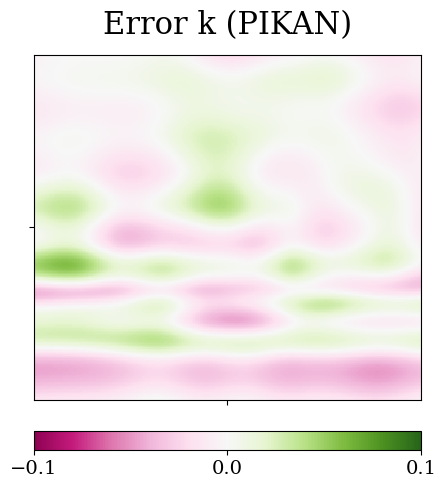

In [26]:
from utils.styled_plots import plot_styled_error

plot_styled_error(X, Y, error_k, title="Error k (PIKAN)", saveas="anl/error_k_pikan.pdf")

In [7]:
from utils.styled_plots import plot_styled_error

plot_styled_error(X, Y, error_k, title="Error k (PINN)", saveas="anl/error_k_pinn.pdf")

(<Figure size 500x575 with 2 Axes>, <Axes: title={'center': 'Error k (PINN)'}>)

In [23]:
# Requirements: PyTorch + pykan
# pip install torch pykan

import torch
from kan import KAN
import numpy as np
# === Architecture inferred from your weights ===
# Inputs: 2 (x, y)
# Hidden layers: 8, 8, 8, 8
# Output: 1 (z)
# Spline settings inferred from state_dict: grid=10, k=3
width = [2, 6,6,6, 1]
grid = 3
k = 3

# === Build the model and load weights ===
model = KAN(width=width, grid=grid, k=k)
state_dict = torch.load("/Users/gregorioperez/Documents/PINNS/PINN-PIKAN-Poisson/infinite/results_kan/models/model_k_weights_kan(3,6).pth", map_location="cpu")
model.load_state_dict(state_dict)
model.eval()

# === Helper: predict z given x and y ===
@torch.no_grad()
def predict_z(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    x, y: 1D or 2D tensors with the same length/first-dimension.
         If 1D, they will be reshaped to (N, 1).
    returns: z tensor of shape (N, 1)
    """
    if x.ndim == 1:
        x = x.unsqueeze(1)
    if y.ndim == 1:
        y = y.unsqueeze(1)
    inp = torch.cat([x, y], dim=1)  # shape (N, 2)
    return model(inp)

# 3) Grid y evaluación
x = np.linspace(-3, 3, 250)
y = np.linspace(-3, 3, 250)
X, Y = np.meshgrid(x, y)

with torch.no_grad():
    coords = torch.from_numpy(np.stack([X.ravel(), Y.ravel()], axis=1)).float()
    Z = model(coords).detach().cpu().numpy().reshape(X.shape)

checkpoint directory created: ./model
saving model version 0.0


/var/folders/1z/lkjj_d294bg99hybc2v704bm0000gn/T/ipykernel_33452/2845030230.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/Users/gregoriopere

In [21]:
from utils.styled_plots import plot_styled_k

In [22]:
plot_styled_k(X, Y, Z, title="k approximation (PIKAN)", saveas="anl/k_approx_kan.pdf")

(<Figure size 500x575 with 2 Axes>,
 <Axes: title={'center': 'k approximation (PIKAN)'}>)